# load libraries and prepare data

In [ ]:
# this is for Google drive and Colab. Remove if not need
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

import math
import random

In [ ]:
num_classes = 10
IMG_SHAPE = (32, 32, 3)
print_shape = (32,32,3)
BATCH_SIZE = 512

# Size of the noise vector
noise_dim = 128

data_set_object = keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = data_set_object.load_data()

x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

# Make sure images have shape (32, 32, 3)
x_train = x_train.reshape(x_train.shape[0], *IMG_SHAPE)#np.expand_dims(x_train, -1)
x_test = x_test.reshape(x_test.shape[0], *IMG_SHAPE)#np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

print(x_train.shape[0], "x_train samples")
print(x_test.shape[0], "x_test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

170498071/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
50000 x_train samples
10000 x_test samples
y_train shape: (50000, 10)
y_test shape: (10000, 10)


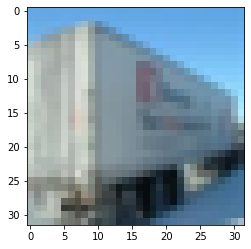

0.0
1.0


In [ ]:
plt.imshow(x_train[15].reshape(print_shape))
plt.show()
print(x_train.min())
print(x_train.max())

# define building blocks

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        # layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def trans_block(x, filters, kernel, strides, out_activation='tanh'):
    # x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters, kernel, strides, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = tfa.layers.GELU()(x)
    x = layers.SpatialDropout2D(0.3)(x)

    x = layers.Conv2D(filters, kernel, strides, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = tfa.layers.GELU()(x)
    x = layers.SpatialDropout2D(0.3)(x)

    # x = layers.Conv2D(filters, kernel, strides, padding='same')(x)
    x = layers.Conv2D(IMG_SHAPE[-1], kernel, strides, padding='same', activation=out_activation)(x)
    # x = layers.BatchNormalization()(x)

    return x

In [ ]:
def trans_block_advance(x, 
            resblock_num=2, 
            initial_filters=16, 
            output_channel=IMG_SHAPE[-1], 
            start_filter=(7,7), 
            end_filter=(7,7),
            down_filter=(3,3), 
            down_step=2, 
            use_bias=False, 
            out_activation='tanh',
            long_skip=True,
            apply_additional_resblock_for_sampling=1,
            up_sample_mode='nearest' #including bilinear, nearest, and transpose
            ):

    x = layers.Conv2D(initial_filters, start_filter, (1,1), padding='same', use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)

    x = tfa.layers.GELU()(x)
    x = layers.SpatialDropout2D(0.3)(x)

    l_skip=[]
    for i in range(down_step):
        for j in range(apply_additional_resblock_for_sampling):
            x_id = x 
            x = layers.Conv2D(initial_filters*(2**i), (3,3), (1,1), padding='same', use_bias=use_bias)(x)
            x = layers.BatchNormalization()(x)

            x = tfa.layers.GELU()(x)
            x = layers.SpatialDropout2D(0.3)(x)

            x = layers.Conv2D(initial_filters*(2**i), (3,3), (1,1), padding='same', use_bias=use_bias)(x)
            x = layers.BatchNormalization()(x)

            x = layers.Add()([x,x_id])
            x = tfa.layers.GELU()(x)

        if long_skip:
            l_skip.append(x)
    
        x = layers.Conv2D(initial_filters*(2**(i+1)), down_filter, (2,2), padding='same', use_bias=use_bias)(x)
        x = layers.BatchNormalization()(x)

        x = tfa.layers.GELU()(x)
        x = layers.SpatialDropout2D(0.3)(x)

    
    for _ in range(resblock_num):
        x_id = x 
        x = layers.Conv2D(initial_filters*(2**down_step), (3,3), (1,1), padding='same', use_bias=use_bias)(x)
        x = layers.BatchNormalization()(x)

        x = tfa.layers.GELU()(x)
        x = layers.SpatialDropout2D(0.3)(x)

        x = layers.Conv2D(initial_filters*(2**down_step), (3,3), (1,1), padding='same', use_bias=use_bias)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([x,x_id])
        x = tfa.layers.GELU()(x)
    
    for i in range(down_step):
        if up_sample_mode=='transpose':
            x = layers.Conv2DTranspose(initial_filters*(2**(down_step-(i+1))), down_filter, (2,2), padding='same', use_bias=use_bias)(x)
        else:
            x = layers.UpSampling2D((2,2), interpolation=up_sample_mode)(x)
            x = layers.Conv2D(initial_filters*(2**(down_step-(i+1))), down_filter, (1,1), padding='same', use_bias=use_bias)(x)
        x = layers.BatchNormalization()(x)

        x = tfa.layers.GELU()(x)
        x = layers.SpatialDropout2D(0.3)(x)

        if long_skip:
            x = layers.Concatenate()([x,l_skip[down_step-(i+1)]])
        
        for j in range(apply_additional_resblock_for_sampling):
            x_id = x 
            x = layers.Conv2D(initial_filters*(2**(down_step-(i+1)))*2, (3,3), (1,1), padding='same', use_bias=use_bias)(x)
            x = layers.BatchNormalization()(x)

            x = tfa.layers.GELU()(x)
            x = layers.SpatialDropout2D(0.3)(x)

            x = layers.Conv2D(initial_filters*(2**(down_step-(i+1)))*2, (3,3), (1,1), padding='same', use_bias=use_bias)(x)
            x = layers.BatchNormalization()(x)

            x = layers.Add()([x,x_id])
            x = tfa.layers.GELU()(x)

    x = layers.Conv2D(output_channel, end_filter, (1,1), padding='same', activation=out_activation, use_bias=use_bias)(x)

    return x

In [ ]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.SpatialDropout2D(0.3)(x) #I added a drop out here for each resblock <--
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def trans_block_unet(x, widths = [32, 64, 96, 128], block_depth=2, out_channel=IMG_SHAPE[-1], out_activation='tanh'):
    
    x = layers.Conv2D(widths[0], kernel_size=1)(x)
    x = layers.SpatialDropout2D(0.3)(x) #I added a drop out here  <--

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.SpatialDropout2D(0.3)(x) #I added a drop out here  <--
    x = layers.Conv2D(out_channel, kernel_size=1, kernel_initializer="zeros", activation=out_activation)(x)

    return x

In [ ]:
def trans_block_attention(x, mapping_dim=12, mapping_size=(2,2), head_num=16, attention_drop=0.1, out_dim=IMG_SHAPE[-1], layer_num=3, out_activation='tanh', end_res_block=1):
    block_in = x
    in_dim = x.shape[-1]

    x = layers.Conv2D(mapping_dim, mapping_size,mapping_size)(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)

    for _ in range(layer_num):
        x_skip = x 
        x = layers.MultiHeadAttention(head_num, key_dim=mapping_dim, dropout=attention_drop)(x,x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x,x_skip])

        x_skip = x
        x = layers.Conv2D(mapping_dim,(1,1),(1,1))(x)
        x = layers.BatchNormalization()(x)
        x = tfa.layers.GELU()(x)

        x = layers.SpatialDropout2D(0.3)(x)

        x = layers.Conv2D(mapping_dim,(1,1),(1,1))(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Add()([x,x_skip])

    x = layers.SpatialDropout2D(0.3)(x)
    # x = layers.Conv2DTranspose(out_dim, mapping_size, mapping_size, activation=out_activation)(x)
    x = layers.UpSampling2D(mapping_size, interpolation='nearest')(x)

    x = layers.Concatenate()([x,block_in])

    for _ in range(end_res_block):
        x_asc = x
        x = layers.Conv2D(mapping_dim+in_dim, (3,3),(1,1), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = tfa.layers.GELU()(x)

        x = layers.SpatialDropout2D(0.3)(x)

        x = layers.Conv2D(mapping_dim+in_dim, (3,3),(1,1), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x,x_asc])

        x = tfa.layers.GELU()(x)

    x = layers.Conv2D(out_dim, (3,3),(1,1), padding='same', use_bias=False, activation=out_activation)(x)


    return x

# build model and train

In [ ]:
#################################
# overall model settings
is_activate=True
is_batchnorm=False
block_activation=None
att_head_num=10
data_aug_layers=False
use_seq_aug_model=True
color_drop=False
#################################

input = layers.Input(IMG_SHAPE)
x = input

if data_aug_layers:
    x = layers.Normalization()(x)
    # x = layers.RandomTranslation(0.1,0.1)(x)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(factor=0.02)(x)
    x = layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)
    # x = layers.RandomContrast(0.1)(x)
if use_seq_aug_model:
    x = data_augmentation(x)
if color_drop:
    x = layers.SpatialDropout2D(0.1)(x)

# x = layers.Conv2D(16,(1,1),(1,1))(x)

xs1 = x
xa = x = trans_block_advance(x, 
                resblock_num=1, initial_filters=8, start_filter=(3,3),end_filter=(3,3), down_filter=(3,3), down_step=0, apply_additional_resblock_for_sampling=1,
                out_activation=block_activation)

x = layers.Multiply()([xs1,x])
if is_batchnorm:
    x = layers.BatchNormalization()(x)
    # x = layers.LayerNormalization()(x)
if is_activate:
    x = tfa.layers.GELU()(x)


xs2 = x
x = layers.Concatenate()([xs1,xs2])
xa = x = trans_block_advance(x, 
                resblock_num=2, initial_filters=16, start_filter=(3,3),end_filter=(3,3), down_filter=(3,3), down_step=1, apply_additional_resblock_for_sampling=2,
                out_activation=block_activation)

x = layers.Multiply()([xs1,x])
if is_batchnorm:
    x = layers.BatchNormalization()(x)
    # x = layers.LayerNormalization()(x)
if is_activate:
    x = tfa.layers.GELU()(x)


xs3 = x
x = layers.Concatenate()([xs1,xs2,xs3])
xa = x = trans_block_advance(x, 
                resblock_num=3, initial_filters=32, start_filter=(3,3),end_filter=(3,3), down_filter=(3,3), down_step=2, apply_additional_resblock_for_sampling=3,
                out_activation=block_activation)

x = layers.Multiply()([xs1,x])
if is_batchnorm:
    x = layers.BatchNormalization()(x)
    # x = layers.LayerNormalization()(x)
if is_activate:
    x = tfa.layers.GELU()(x)


xs4 = x
# x = layers.Concatenate()([xs1,xs2,xs3,xs4])
# xa = x = trans_block_advance(x, 
#                 resblock_num=2, initial_filters=32, start_filter=(3,3),end_filter=(3,3), down_filter=(3,3), down_step=1, apply_additional_resblock_for_sampling=2,
#                 out_activation=block_activation)

# x = layers.Multiply()([xs1,x])
# if is_batchnorm:
#     x = layers.BatchNormalization()(x)
#     # x = layers.LayerNormalization()(x)
# if is_activate:
#     x = tfa.layers.GELU()(x)


xs5 = x
# x = layers.Concatenate()([xs1,xs2,xs3,xs4,xs5])
# xa = x = trans_block_advance(x, 
#                 resblock_num=2, initial_filters=64, start_filter=(3,3),end_filter=(3,3), down_filter=(3,3), down_step=2, apply_additional_resblock_for_sampling=2,
#                 out_activation=block_activation)

# x = layers.Multiply()([xs1,x])
# if is_batchnorm:
#     x = layers.BatchNormalization()(x)
#     # x = layers.LayerNormalization()(x)
# if is_activate:
#     x = tfa.layers.GELU()(x)

xs6 = x #<additional for interpretation I just following "xs" format(x_skip)

x_AP = x = layers.AveragePooling2D((2,2))(x)
x = layers.MultiHeadAttention(att_head_num,key_dim=3,dropout=0.1,output_shape=num_classes)(x,x)
# x = layers.Add()([x,x_AP])

x = layers.GlobalAveragePooling2D()(x)


classifier = keras.Model(input,x,name='classifier')
classifier.summary()

# we also save the inner output as indepent model for convenience and we can call these models to see the feature maps
IO_model_2 = keras.Model(input, xs2)
IO_model_3 = keras.Model(input, xs3)
IO_model_4 = keras.Model(input, xs4)
IO_model_5 = keras.Model(input, xs5)
IO_model_6 = keras.Model(input, xs6)

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 32, 32, 3)   7           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    216         ['data_augmentation[0][0]']      
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                              

In [ ]:
loss_func = keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tfa.optimizers.AdamW(weight_decay=0.0001) #keras.optimizers.Adam()
classifier.compile(optimizer=optimizer,
        loss=loss_func,
        metrics=['acc', 'top_k_categorical_accuracy'],
        )

# fit

In [ ]:
classifier.fit(x_train, y_train, epochs=150, batch_size=BATCH_SIZE, validation_data=[x_test,y_test])

In [ ]:
classifier.evaluate(x_test,y_test)

In [ ]:
# this is for Google drive and Colab. Remove if not need
classifier.save("/content/drive/MyDrive/Colab Notebooks/can NN learn uncertain?/saved_weights/classifier")

In [ ]:
# this is for Google drive and Colab. Remove if not need
# save the the inner feature map output segment as independent model, just for convenient use
IO_model_2.save("/content/drive/MyDrive/Colab Notebooks/can NN learn uncertain?/saved_weights/IO_model_2")
IO_model_3.save("/content/drive/MyDrive/Colab Notebooks/can NN learn uncertain?/saved_weights/IO_model_3")
IO_model_4.save("/content/drive/MyDrive/Colab Notebooks/can NN learn uncertain?/saved_weights/IO_model_4")
IO_model_5.save("/content/drive/MyDrive/Colab Notebooks/can NN learn uncertain?/saved_weights/IO_model_5")
IO_model_6.save("/content/drive/MyDrive/Colab Notebooks/can NN learn uncertain?/saved_weights/IO_model_6")

In [ ]:
# this is just an experiment to show how model react to random noise
noise_test = np.random.normal(0, 1, IMG_SHAPE)
original_image_strength=1

testment_idx=1  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<change this for test image

test_label=y_test[testment_idx]

plt.imshow(x_test[testment_idx].reshape(print_shape))
plt.show()
plt.imshow(noise_test.reshape(print_shape))
plt.show()

record_list=[[],[],[],[],[],[],[],[],[],[],[]]
strength_list=[]
for i in range(-50,51):
    noise_strength = i/100
    test_img = noise_test * noise_strength + x_test[testment_idx]*original_image_strength
    # test_img=np.clip(test_img,0,1)
    noise_pred = classifier.predict(test_img.reshape(1,*IMG_SHAPE))
    
    #softmax the probability
    # noise_pred=tf.nn.softmax(noise_pred).numpy()
    # print(np.sum(noise_pred))

    strength_list.append(noise_strength)
    for j in range(10):
        record_list[j].append(noise_pred[0][j])
print(record_list)

y_test[1]

In [ ]:
label_text=['plane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# label_text=['0','1','2','3','4','5','6','7','8','9']
plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(strength_list, record_list[i], label=label_text[i]) 
    # if i == 16:
    #     plt.plot(strength_list, record_list[i], marker='o') 
    # elif i == test_label.argmax()+10:
    #     plt.plot(strength_list, record_list[i], marker='^') 
    # else:
    #     plt.plot(strength_list, record_list[i])
plt.legend(loc='upper right')
# plt.xlim([-1,1])
plt.show()

# feature maps and weights visualization

In [ ]:
# test_oidex=15+13*4-0+0
inter_output_model = IO_model_6 #keras.Model(classifier.input, classifier.get_layer(index = test_oidex).output )
inter_output = inter_output_model.predict(x_test[:])
print(np.min(inter_output),np.max(inter_output))

In [ ]:
print(len(inter_output_model.layers))
weight_model = keras.Model(inter_output_model.input, inter_output_model.get_layer(index = len(inter_output_model.layers)-3).output )
weight_output = weight_model.predict(x_test[:])
print(np.min(weight_output),np.max(weight_output))

In [ ]:
ave_inter_output=tf.nn.avg_pool2d(inter_output,(2,2),(2,2),'VALID').numpy()

In [ ]:
inter_output.shape

In [ ]:
# define the function used to normalize the feature maps and weights
def vnormz(v):
    return (v-np.min(v))/(np.max(v)-np.min(v))

In [ ]:
inspect_idx=1
print("original")
plt.imshow(x_test[inspect_idx].reshape(print_shape))
plt.show()

print("feature map")
plt.imshow(inter_output[inspect_idx,:,:,:])
plt.show()
print("normalized feature map")
plt.imshow(vnormz(inter_output[inspect_idx,:,:,:]))
plt.show()
print("ave feature map")
plt.imshow(ave_inter_output[inspect_idx,:,:,:])
plt.show()
print("weights")
plt.imshow(weight_output[inspect_idx,:,:,:])
plt.show()
print("normalized weights")
plt.imshow(vnormz(weight_output[inspect_idx,:,:,:]))
plt.show()
print("feature map channels rgb")
for i in range(inter_output.shape[-1]):
    print("---==--=-=-=-=-=-=-=-=-=")
    plt.imshow(inter_output[inspect_idx,:,:,i])
    plt.show()
    plt.imshow(weight_output[inspect_idx,:,:,i])
    plt.show()